In [1]:
import numpy as np
import matplotlib.pyplot as plt

import uproot
import hist
import awkward as ak
import vector
vector.register_awkward()

import torch
import pandas as pd

from model import vertexMLP, vertexReg, vertexTag

In [2]:
# net = vertexMLP(hidden_dim1=32, hidden_dim2=32)
net = torch.load('net.pt')
net.eval()

vertexMLP(
  (fc1): vertexTag(
    (fc1): Linear(in_features=13, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=5, bias=True)
  )
  (fc2): vertexReg(
    (fc1): Linear(in_features=18, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [3]:
event_file = uproot.open("evt_tree.root")

trk_tree = event_file["trk_tree"]
trk_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | evt                      | AsGroup(<TBranchElement 'ev...
event/id             | int32_t                  | AsDtype('>i4')
event/rec_stat       | int32_t                  | AsDtype('>i4')
event/weight         | double                   | AsDtype('>f8')
event/rec_ndim       | int32_t                  | AsDtype('>i4')
rec_trk              | trk                      | AsGroup(<TBranchElement 're...
rec_trk/q            | int32_t                  | AsDtype('>i4')
rec_trk/x1           | double                   | AsDtype('>f8')
rec_trk/y1           | double                   | AsDtype('>f8')
rec_trk/z1           | double                   | AsDtype('>f8')
rec_trk/px1          | double                   | AsDtype('>f8')
rec_trk/py1          | double                   | AsDtype('>f8')
rec_trk/pz1          | dou

In [4]:
trk_data = trk_tree.arrays(["event/id", "event/rec_ndim", "rec_trk/q", "rec_trk/x1", "rec_trk/y1", "rec_trk/z1",
                            "rec_trk/x3", "rec_trk/y3", "rec_trk/z3", "rec_trk/px1", "rec_trk/py1", "rec_trk/pz1",
                           "rec_trk/px3", "rec_trk/py3", "rec_trk/pz3"], library="pd")

trk_data = trk_data[trk_data["event/rec_ndim"]==1]

trk_data = trk_data[["event/id","rec_trk/q", "rec_trk/x1", "rec_trk/y1", "rec_trk/z1", "rec_trk/x3",
                      "rec_trk/y3", "rec_trk/z3", "rec_trk/px1", "rec_trk/py1", "rec_trk/pz1",
                      "rec_trk/px3", "rec_trk/py3", "rec_trk/pz3"]].to_numpy()

In [5]:
X_test = trk_data[:, 1:]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [7]:
pred_hotid, y_pred = net(torch.tensor(X_test).unsqueeze(0).float())
y_pred = y_pred.squeeze().detach().numpy()

In [8]:
# mass of the muon
mu_mass = 0.106

single_mu = ak.zip({
    "event_id": trk_data[:, 0],
    "charge": trk_data[:, 1],
    "px": y_pred[:, 3],
    "py": y_pred[:, 4],
    "pz": y_pred[:, 5],
    "mass": mu_mass,
}, with_name="Momentum4D")

In [9]:
# hist.Hist.new.Regular(200000, 0, 200000).Double().fill(ak.ravel(single_mu.event_id)).plot();

In [10]:
p_mom = single_mu[single_mu.charge==+1]
n_mom= single_mu[single_mu.charge==-1]

In [11]:
p_pos, p_neg = ak.unzip(ak.cartesian([p_mom, n_mom], axis=0))

In [12]:
event_selection = (p_pos.event_id == p_neg.event_id)

# charge_selection = p_pos[event_selection].charge + p_neg[event_selection].charge == 0.0

In [13]:
ak.sum(event_selection)

20341

In [14]:
ak.size(single_mu.event_id)

40682

In [15]:
ak.size(p_pos[event_selection])

20341

In [16]:
ak.size(p_neg[event_selection])

20341

In [17]:
# hist.Hist.new.Regular(3, -1.5, 1.5).Double().fill(ak.ravel(p_pos[event_selection].charge)).plot();

In [18]:
dim_tree = event_file["dim_tree"]
dim_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | evt                      | AsGroup(<TBranchElement 'ev...
event/id             | int32_t                  | AsDtype('>i4')
event/rec_stat       | int32_t                  | AsDtype('>i4')
event/weight         | double                   | AsDtype('>f8')
event/rec_ndim       | int32_t                  | AsDtype('>i4')
true_dim             | dim                      | AsGroup(<TBranchElement 'tr...
true_dim/mass        | double                   | AsDtype('>f8')
true_dim/energy      | double                   | AsDtype('>f8')
true_dim/pt          | double                   | AsDtype('>f8')
true_dim/x1          | double                   | AsDtype('>f8')
true_dim/x2          | double                   | AsDtype('>f8')
true_dim/xf          | double                   | AsDtype('>f8')
true_dim/costh       | dou

In [19]:
dim_data = dim_tree.arrays(["event/rec_ndim", "true_dim/mass", "true_dim/energy", "true_dim/pt",
                           "true_dim/x1", "true_dim/x2", "true_dim/xf", "true_dim/costh", "true_dim/phi"], library="pd")

In [20]:
dim_data = dim_data[dim_data["event/rec_ndim"]==1]

In [21]:
dim_data = dim_data[["true_dim/mass", "true_dim/energy", "true_dim/pt", "true_dim/x1",
                     "true_dim/x2", "true_dim/xf", "true_dim/costh", "true_dim/phi"]].to_numpy()

In [22]:
np.shape(dim_data)

(20341, 8)

In [23]:
mp = 0.938
ebeam = 120.

p_beam = ak.zip({
    "px": 0.,
    "py": 0.,
    "pz": np.sqrt(ebeam*ebeam - mp*mp),
    "energy": ebeam,
}, with_name="Momentum4D")

p_target = ak.zip({
    "px": 0.,
    "py": 0.,
    "pz": 0.,
    "energy": mp,
}, with_name="Momentum4D")

In [24]:
p_pos = p_pos[event_selection]
p_neg = p_neg[event_selection]

p_cms = p_beam + p_target
p_sum = (p_pos + p_neg)

In [25]:
mass = p_sum.mass
pT = p_sum.pt

In [26]:
x1 = (p_target@p_sum)/(p_target@p_cms)
x2 = (p_beam@p_sum)/(p_beam@p_cms)

In [27]:
s = p_cms.tau2
bv_cms = p_cms.to_beta3()
p_boost = p_sum.boost(-bv_cms)
xF = 2.*p_boost.pz/np.sqrt(s)/(1. - mass*mass/s)

In [28]:
mass_selection = (0.0 <= mass) & (mass <= 10.0)

In [29]:
ak.sum(mass_selection)

20321

In [30]:
x1_selection = (0.0 <= x1[mass_selection]) & (x1[mass_selection] <=1.0)

In [31]:
ak.sum(x1_selection)

19034

In [32]:
x2_selection = (0.0 <= x1[mass_selection][x1_selection]) & (x1[mass_selection][x1_selection] <=1.0)

In [33]:
ak.sum(x2_selection)

19034

In [34]:
xf_selection = np.abs(xF[mass_selection][x1_selection][x2_selection]) <= 1.0

In [35]:
ak.sum(xf_selection)

19033

In [36]:
pz_cut = (p_pos.pz[mass_selection][x1_selection][x2_selection][xf_selection] + p_neg.pz[mass_selection][x1_selection][x2_selection][xf_selection] <= 120.) & (30. <= p_pos.pz[mass_selection][x1_selection][x2_selection][xf_selection] + p_neg.pz[mass_selection][x1_selection][x2_selection][xf_selection]) 

In [37]:
ak.sum(pz_cut)

18917

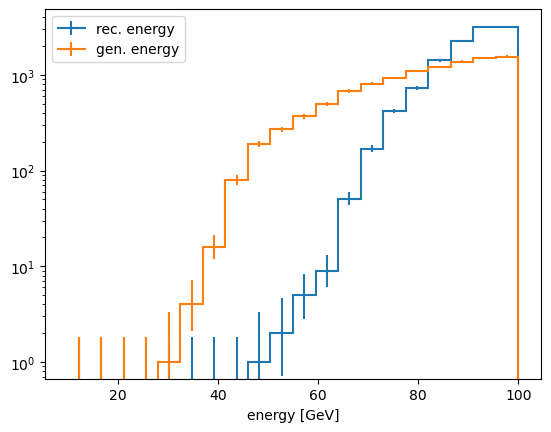

In [38]:
hist.Hist.new.Regular(20, 10., 100.).Double().fill(p_sum.energy[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. energy")
hist.Hist.new.Regular(20, 10., 100.).Double().fill(dim_data[:, 1]).plot(label="gen. energy")
plt.xlabel("energy [GeV]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/energy.png")
plt.show()

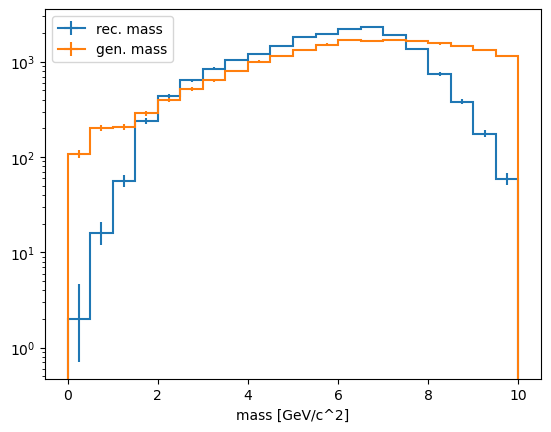

In [39]:
hist.Hist.new.Regular(20, 0., 10.).Double().fill(mass[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. mass")
hist.Hist.new.Regular(20, 0., 10.).Double().fill(dim_data[:, 0]).plot(label="gen. mass")
plt.xlabel("mass [GeV/c^2]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/mass.png")
plt.show()

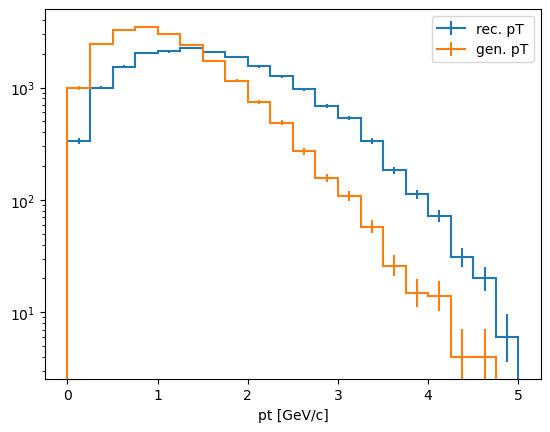

In [40]:
hist.Hist.new.Regular(20, 0., 5.).Double().fill(pT[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. pT")
hist.Hist.new.Regular(20, 0., 5.).Double().fill(dim_data[:, 2]).plot(label="gen. pT")
plt.xlabel("pt [GeV/c]")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/pt.png")
plt.show()

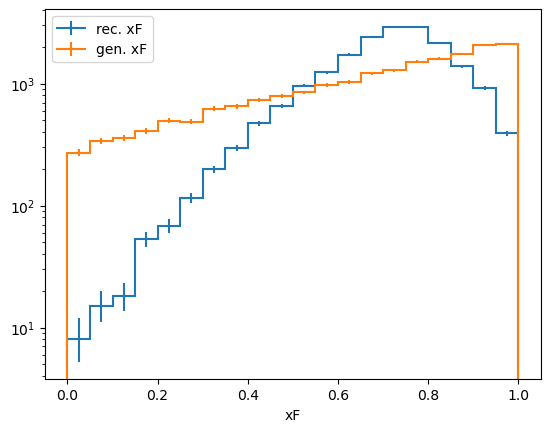

In [41]:
hist.Hist.new.Regular(20, 0., 1.).Double().fill(xF[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. xF")
hist.Hist.new.Regular(20, 0., 1.).Double().fill(dim_data[:, 5]).plot(label="gen. xF")
plt.xlabel("xF")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/xf.png")
plt.show()

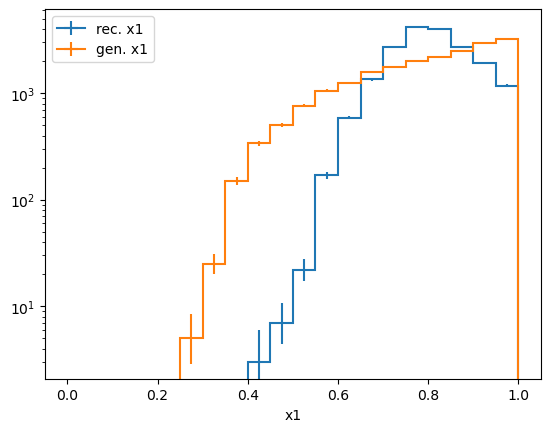

In [42]:
hist.Hist.new.Regular(20, 0., 1.).Double().fill(x1[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. x1")
hist.Hist.new.Regular(20, 0., 1.).Double().fill(dim_data[:, 3]).plot(label="gen. x1")
plt.xlabel("x1")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/x1.png")
plt.show()

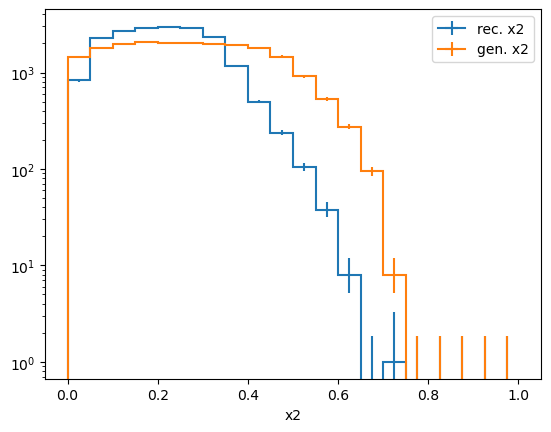

In [43]:
hist.Hist.new.Regular(20, 0., 1.).Double().fill(x2[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. x2")
hist.Hist.new.Regular(20, 0., 1.).Double().fill(dim_data[:, 4]).plot(label="gen. x2")
plt.xlabel("x2")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/x2.png")
plt.show()

In [44]:
costh = 2.*(p_neg.E*p_pos.pz - p_pos.E*p_neg.pz)/mass/np.sqrt(mass*mass + pT*pT)

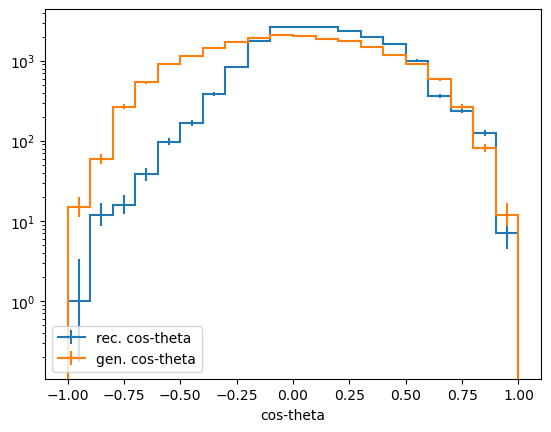

In [45]:
hist.Hist.new.Regular(20, -1.0, 1.0).Double().fill(costh[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. cos-theta")
hist.Hist.new.Regular(20, -1., 1.).Double().fill(dim_data[:, 6]).plot(label="gen. cos-theta")
plt.xlabel("cos-theta")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/cos-theta.png")
plt.show()

In [46]:
phi = np.arctan2(2.*np.sqrt(mass*mass + pT*pT)*(p_neg.x*p_pos.y - p_pos.x*p_neg.y), mass*(p_pos.x*p_pos.x - p_neg.x*p_neg.x + p_pos.y*p_pos.y - p_neg.y*p_neg.y))

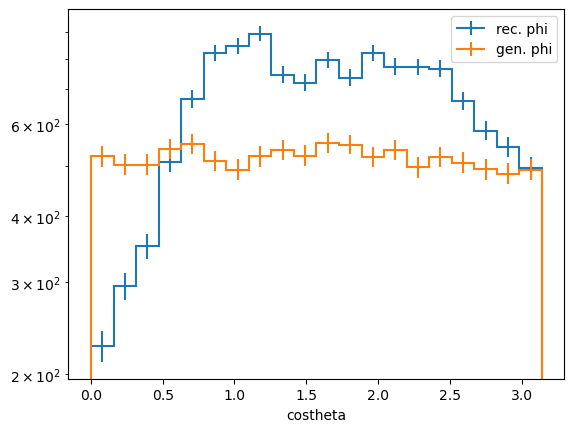

In [47]:
hist.Hist.new.Regular(20, 0.0, np.pi).Double().fill(phi[mass_selection][x1_selection][x2_selection][xf_selection][pz_cut]).plot(label="rec. phi")
hist.Hist.new.Regular(20, 0.0, np.pi).Double().fill(dim_data[:, 7]).plot(label="gen. phi")
plt.xlabel("costheta")
plt.yscale("log")
plt.legend()
plt.savefig("imgs/phi.png")
plt.show()